In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from glob import glob 

import pandas as pd

from fastcore.xtras import load_pickle

from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

%matplotlib inline

## Load results

In [26]:
all_out = glob("out/**/*.pkl")

In [27]:
all_out = [load_pickle(p) for p in all_out]

In [28]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out: 
    try:
        res = {
            'train_size': out['train_size'],
            'frac_valid': out['frac_valid'],
            'accuracy': out['accuracy'],
            'f1_macro': out['f1_macro'],
            'f1_micro': out['f1_micro'],
            'kappa': out['kappa'],
            "num_classes": out['num_classes'],
            "representation": out['representation']
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        'train_size': out['train_size'], 
        'accuracy': out['xgboost_baseline']['accuracy'], 
        'f1_macro': out['xgboost_baseline']['f1_macro'],
        'f1_micro': out['xgboost_baseline']['f1_micro'],
        'kappa': out['xgboost_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

    tabpfn_res = {
        'train_size': out['train_size'], 
        'accuracy': out['tabpfn_baseline']['accuracy'], 
        'f1_macro': out['tabpfn_baseline']['f1_macro'],
        'f1_micro': out['tabpfn_baseline']['f1_micro'],
        'kappa': out['tabpfn_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

    
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [29]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [30]:
grouped_res = res.groupby(['num_classes', "representation", 'train_size']).agg(['mean', 'std'])

In [31]:
grouped_xgboost_res = xgboost_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std'])

In [32]:
grouped_tabpfn_res = tabpfn_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std'])

In [33]:
grouped_res.loc[2,:]

frac_valid       accuracy            f1_macro  \
                                mean  std      mean       std      mean   
representation train_size                                                 
SMILES         10                1.0  0.0  0.651111  0.061734  0.625075   
               20                1.0  0.0  0.742857  0.081387  0.734850   
               50                1.0  0.0  0.813750  0.047189  0.813215   
               100               1.0  0.0  0.860000  0.027775  0.859436   
               200               1.0  0.0  0.873750  0.032923  0.873348   
inchi          10                1.0  0.0  0.581111  0.085505  0.531864   
               20                1.0  0.0  0.785714  0.036450  0.782149   
               50                1.0  0.0  0.827143  0.022887  0.826072   
               100               1.0  0.0  0.837500  0.041662  0.836889   
               200               1.0  0.0  0.857143  0.041519  0.857033   
name           10                1.0  0.0  0.750531  0.105258  0.734918   
               20                1.0  0.0  0.819853  0.044984  0.817788   
               50                1.0  0.0  0.861404  0.040362  0.860225   
selfies        10                1.0  0.0  0.571111  0.078652  0.522552   
               20                1.0  0.0  0.702857  0.075656  0.700457   
               50                1.0  0.0  0.761429  0.047759  0.760378   
               100               1.0  0.0  0.840000  0.041057  0.839461   
               200               1.0  0.0  0.847143  0.061023  0.846783   

                                     f1_micro               kappa            
                                std      mean       std      mean       std  
representation train_size                                                    
SMILES         10          0.084438  0.651111  0.061734  0.302222  0.123468  
               20          0.089949  0.742857  0.081387  0.485714  0.162774  
               50          0.047458  0.813750  0.047189  0.627500  0.094378  
               100         0.027739  0.860000  0.027775  0.720000  0.055549  
               200         0.033410  0.873750  0.032923  0.747500  0.065846  
inchi          10          0.134710  0.581111  0.085505  0.162222  0.171010  
               20          0.038564  0.785714  0.036450  0.571429  0.072899  
               50          0.023790  0.827143  0.022887  0.654286  0.045774  
               100         0.041889  0.837500  0.041662  0.675000  0.083324  
               200         0.041474  0.857143  0.041519  0.714286  0.083038  
name           10          0.138958  0.750531  0.105258  0.501062  0.210516  
               20          0.045643  0.819853  0.044984  0.639706  0.089969  
               50          0.041160  0.861404  0.040362  0.722807  0.080724  
selfies        10          0.112174  0.571111  0.078652  0.142222  0.157304  
               20          0.074788  0.702857  0.075656  0.405714  0.151312  
               50          0.049437  0.761429  0.047759  0.522857  0.095519  
               100         0.041077  0.840000  0.041057  0.680000  0.082115  
               200         0.061119  0.847143  0.061023  0.694286  0.122046

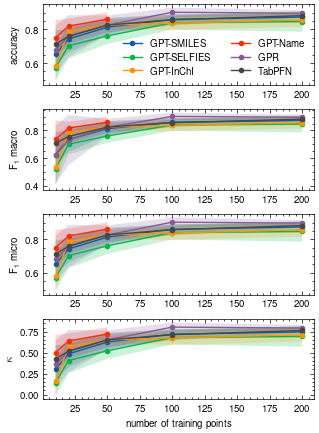

In [34]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[2, 'SMILES', :].index,
        grouped_res.loc[2, 'SMILES', :][metric]['mean'],
        marker='o',
        label='GPT-SMILES',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'SMILES', :].index,
        grouped_res.loc[2, 'SMILES', :][metric]['mean'] - grouped_res.loc[2, 'SMILES', :][metric]['std'],
        grouped_res.loc[2, 'SMILES', :][metric]['mean'] + grouped_res.loc[2, 'SMILES', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[2, 'selfies', :].index,
        grouped_res.loc[2, 'selfies', :][metric]['mean'],
        marker='o',
        label='GPT-SELFIES',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'selfies', :].index,
        grouped_res.loc[2, 'selfies', :][metric]['mean'] - grouped_res.loc[2, 'selfies', :][metric]['std'],
        grouped_res.loc[2, 'selfies', :][metric]['mean'] + grouped_res.loc[2, 'selfies', :][metric]['std'],
        alpha=0.2,
    )


    ax[i].plot(
        grouped_res.loc[2, 'inchi', :].index,
        grouped_res.loc[2, 'inchi', :][metric]['mean'],
        marker='o',
        label='GPT-InChI',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'inchi', :].index,
        grouped_res.loc[2, 'inchi', :][metric]['mean'] - grouped_res.loc[2, 'inchi', :][metric]['std'],
        grouped_res.loc[2, 'inchi', :][metric]['mean'] + grouped_res.loc[2, 'inchi', :][metric]['std'],
        alpha=0.2,
    )


    ax[i].plot(
        grouped_res.loc[2, 'name', :].index,
        grouped_res.loc[2, 'name', :][metric]['mean'],
        marker='o',
        label='GPT-Name',
    )
    ax[i].fill_between(
        grouped_res.loc[2, 'name', :].index,
        grouped_res.loc[2, 'name', :][metric]['mean'] - grouped_res.loc[2, 'name', :][metric]['std'],
        grouped_res.loc[2, 'name', :][metric]['mean'] + grouped_res.loc[2, 'name', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'],
        marker='o',
        label='GPR'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'] - grouped_xgboost_res.loc[2,:][metric]['std'],
        grouped_xgboost_res.loc[2,:][metric]['mean'] + grouped_xgboost_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'] - grouped_tabpfn_res.loc[2,:][metric]['std'],
        grouped_tabpfn_res.loc[2,:][metric]['mean'] + grouped_tabpfn_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

ax[-1].set_xlabel('number of training points')
ax[0].legend(ncols=2)

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')

fig.tight_layout()
fig.savefig('photoswitch-classification_results_binary.pdf', bbox_inches='tight')

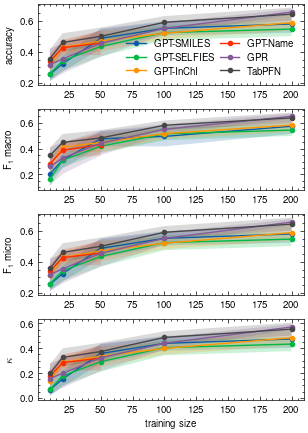

In [35]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[5, 'SMILES', :].index,
        grouped_res.loc[5, 'SMILES', :][metric]['mean'],
        marker='o',
        label='GPT-SMILES',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'SMILES', :].index,
        grouped_res.loc[5, 'SMILES', :][metric]['mean'] - grouped_res.loc[5, 'SMILES', :][metric]['std'],
        grouped_res.loc[5, 'SMILES', :][metric]['mean'] + grouped_res.loc[5, 'SMILES', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[5, 'selfies', :].index,
        grouped_res.loc[5, 'selfies', :][metric]['mean'],
        marker='o',
        label='GPT-SELFIES',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'selfies', :].index,
        grouped_res.loc[5, 'selfies', :][metric]['mean'] - grouped_res.loc[5, 'selfies', :][metric]['std'],
        grouped_res.loc[5, 'selfies', :][metric]['mean'] + grouped_res.loc[5, 'selfies', :][metric]['std'],
        alpha=0.2,
    )


    ax[i].plot(
        grouped_res.loc[5, 'inchi', :].index,
        grouped_res.loc[5, 'inchi', :][metric]['mean'],
        marker='o',
        label='GPT-InChI',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'inchi', :].index,
        grouped_res.loc[5, 'inchi', :][metric]['mean'] - grouped_res.loc[5, 'inchi', :][metric]['std'],
        grouped_res.loc[5, 'inchi', :][metric]['mean'] + grouped_res.loc[5, 'inchi', :][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[5, 'name', :].index,
        grouped_res.loc[5, 'name', :][metric]['mean'],
        marker='o',
        label='GPT-Name',
    )
    ax[i].fill_between(
        grouped_res.loc[5, 'name', :].index,
        grouped_res.loc[5, 'name', :][metric]['mean'] - grouped_res.loc[5, 'name', :][metric]['std'],
        grouped_res.loc[5, 'name', :][metric]['mean'] + grouped_res.loc[5, 'name', :][metric]['std'],
        alpha=0.2,
    )
    
    ax[i].plot(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'],
        marker='o',
        label='GPR'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'] - grouped_xgboost_res.loc[5,:][metric]['std'],
        grouped_xgboost_res.loc[5,:][metric]['mean'] + grouped_xgboost_res.loc[5,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'] - grouped_tabpfn_res.loc[5,:][metric]['std'],
        grouped_tabpfn_res.loc[5,:][metric]['mean'] + grouped_tabpfn_res.loc[5,:][metric]['std'],
        alpha=0.2,
    )

ax[-1].set_xlabel('training size')
ax[0].legend(ncols=2, columnspacing=.5)

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')

fig.tight_layout()
fig.savefig('photoswitch-classification_results_5_class.pdf', bbox_inches='tight')